# GBur-IRIS

In [1]:
import numpy as np
from functools import partial

# To use the MOSEK solver for MaxCliqueSolverViaMip change the path to MOSEK license 
import os
os.environ["MOSEKLM_LICENSE_FILE"] = '/home/dzenan/mosek/mosek.lic'

import sys
filePath = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(1, os.path.join(filePath, "src"))

from pydrake.all import (
    MultibodyPlant,
    RigidTransform,
    RollPitchYaw,
    Parser,
    StartMeshcat,
    ModelVisualizer,
    HPolyhedron,
    RobotDiagramBuilder,
    SceneGraphCollisionChecker,
    AddDefaultVisualization,
    RobotCollisionType,
    IrisFromCliqueCoverOptions,
    IrisInConfigurationSpaceFromCliqueCover,
    RandomGenerator,
    MaxCliqueSolverViaMip,
    MaxCliqueSolverViaGreedy
)

import matplotlib.pyplot as plt
from timeit import default_timer as timer

from VisualizeConfigurationSpace import *
from ManualVCC import *
from PlanarArm import *
from AnthropomorphicArm import *
from GeneralizedBur import *
from GBurIRIS import *

## Loading and visualizing models/scenes using Python code

### 3DOF Flipper

In [2]:
def Load3dofFlipper(plant: MultibodyPlant):
    parser = Parser(plant)

    # Paths to assets
    oneDOFhand = os.path.join(filePath, "assets/flipper/oneDOF_iiwa7_with_box_collision.sdf")
    twoDOFhand = os.path.join(filePath, "assets/flipper/twoDOF_iiwa7_with_box_collision.sdf")
    boxBorder = os.path.join(filePath, "assets/flipper/box_small.urdf")

    # Add assets to plant
    models = []
    models.append(parser.AddModels(boxBorder))
    models.append(parser.AddModels(twoDOFhand))
    models.append(parser.AddModels(oneDOFhand))

    # Rearrange assets
    locs = [[0.,0.,0.],
        [0.,.55,0.],
        [0.,-.55,0.]]
    plant.WeldFrames(plant.world_frame(), 
                    plant.get_body(plant.GetBodyIndices(models[0][0])[0]).body_frame(), # plant.GetFrameByName("base") also works here
                    RigidTransform(locs[0]))
    plant.WeldFrames(plant.world_frame(), 
                    plant.get_body(plant.GetBodyIndices(models[1][0])[0]).body_frame(), # plant.GetFrameByName("iiwa_twoDOF_link_0") also works here
                    RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[1]))
    plant.WeldFrames(plant.world_frame(), 
                    plant.get_body(plant.GetBodyIndices(models[2][0])[0]).body_frame(), # plant.GetFrameByName("iiwa_oneDOF_link_0") also works here
                    RigidTransform(RollPitchYaw([0,0, -np.pi/2]).ToRotationMatrix(), locs[2]))

In [3]:
meshcat1 = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
v = ModelVisualizer(meshcat=meshcat1)
Load3dofFlipper(v.parser().plant())
v.Run()

INFO:drake:Click 'Stop Running' or press Esc to quit


### 7DOF IIWA with shelves

In [5]:
def Load7dofIIWAwithShelves(plant: MultibodyPlant):
    parser = Parser(plant)

    # Paths to assets
    iiwa7_asset = os.path.join(filePath, "assets/iiwa_description/sdf/iiwa7_with_box_collision.sdf")
    shelves_asset = os.path.join(filePath, "assets/shelves.sdf")

    # Drake model directives for WSG
    model_directives = """    
directives:
- add_model:
    name: wsg
    file: file://%s
- add_weld:
    parent: iiwa7::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
""" % os.path.join(filePath, "assets/wsg_50_description/sdf/schunk_wsg_50_welded_fingers.sdf")

    parser.SetAutoRenaming(True) # To avoid naming collision. Using two different parsers also works to get around naming collisions

    # Add assets to plant
    models = []
    models.append(parser.AddModels(iiwa7_asset))
    models.append(parser.AddModelsFromString(model_directives, ".dmd.yaml"))
    models.append(parser.AddModels(shelves_asset))
    models.append(parser.AddModels(shelves_asset))

    # Rearrange assets
    sp = 0.4
    x_fac = 1.2
    locs = [ [0,0,0], 
            [x_fac*sp, 1.4*sp,0.4], [x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,-1.4*sp,0.4], [-x_fac*sp,1.4*sp,0.4], 
            [0.0 ,0 , 0.95], [0.0 ,0 , -0.05]] 
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(models[0][0])[0]).body_frame(),
                    RigidTransform(locs[0]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(models[2][0])[0]).body_frame(),
                    RigidTransform(locs[1]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(models[3][0])[0]).body_frame(),
                    RigidTransform(locs[2]))

In [6]:
meshcat2 = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [7]:
v = ModelVisualizer(meshcat=meshcat2)
Load7dofIIWAwithShelves(v.parser().plant())
v.Run()

INFO:drake:Click 'Stop Running' or press Esc to quit


## Loading and visualizing models/scenes using Drake Model Directives

### 2DOF planar arm with cylinders (obstacles)

In [8]:
meshcat3 = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [9]:
# Change meshcat background
meshcat3.SetProperty("/Background", "top_color", [0.894118, 0.964706, 0.972549, 0.4])
meshcat3.SetProperty("/Background", "bottom_color", [0.894118, 0.964706, 0.972549, 0.4])

In [10]:
v = ModelVisualizer(meshcat=meshcat3)
v.parser().package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
v.parser().AddModels(os.path.join(filePath, "scenes/2dofScene0.dmd.yaml"))
v.Run()

INFO:drake:Click 'Stop Running' or press Esc to quit


## Loading models/scenes and creating collision checkers

In [11]:
meshcat4 = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7003


In [12]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/2dofScene0.dmd.yaml"))
plant.Finalize()

# If model visualization is needed
AddDefaultVisualization(builder.builder(), meshcat4)

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()
plantContext = plant.GetMyMutableContextFromRoot(diagramContext)

# Update visualization
diagram.ForcedPublish(diagramContext)

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("2dofPlanarArm") ],
    edge_step_size=0.1,
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


### Check for collision

In [13]:
# Check for collision
q = [-np.pi / 2, np.pi / 2]
print(checker.CheckConfigCollisionFree(q))

# Update visualization
plant.SetPositions(plantContext, q)
diagram.ForcedPublish(diagramContext)

True


In [14]:
# Check for collision
q = [-np.pi / 2, -np.pi / 2]
print(checker.CheckConfigCollisionFree(q))

# Update visualization
plant.SetPositions(plantContext, q)
diagram.ForcedPublish(diagramContext)

False


## Visualize configuration space

### 3DOF Flipper

In [15]:
meshcat5 = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7004


In [16]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/3dofFlipper.dmd.yaml"))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[
        plant.GetModelInstanceByName("2dofIIWA"),
        plant.GetModelInstanceByName("1dofIIWA")
        ],
    edge_step_size=0.1,
)

N = 70
visualize3dConfigSpace(meshcat5, checker, N)

INFO:drake:Allocating contexts to support implicit context parallelism 4


### 2DOF planar arm with cylinders (obstacles)

INFO:drake:Allocating contexts to support implicit context parallelism 4


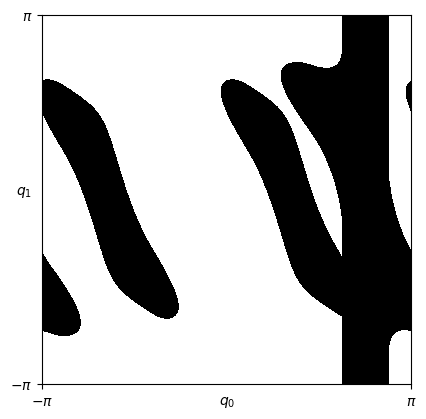

In [17]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/2dofScene0.dmd.yaml"))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("2dofPlanarArm") ],
    edge_step_size=0.1,
)

N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))
plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

## Using the Drake implementation of the Visibility Clique Covering (VCC) algorithm

### 3DOF Flipper

#### Using greedy MaxClique solver

In [18]:
vcc_opts = IrisFromCliqueCoverOptions()

vcc_opts.coverage_termination_threshold = 0.8
vcc_opts.num_points_per_visibility_round = 500
vcc_opts.num_points_per_coverage_check = 5000
vcc_opts.minimum_clique_size = 10

In [19]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/3dofFlipper.dmd.yaml"))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[
        plant.GetModelInstanceByName("2dofIIWA"),
        plant.GetModelInstanceByName("1dofIIWA")
        ],
    edge_step_size=0.1,
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


In [20]:
pre_existing_regions = []
vcc_regions = IrisInConfigurationSpaceFromCliqueCover(
    checker, vcc_opts, RandomGenerator(1337), pre_existing_regions)

INFO:drake:Using default max clique solver MaxCliqueSolverViaGreedy.
INFO:drake:Current Fraction of Domain Covered = 0
INFO:drake:IrisFromCliqueCover Iteration 1/100


INFO:drake:Clique added to queue. There are 275/500 points left to cover.
INFO:drake:Clique added to queue. There are 209/500 points left to cover.
INFO:drake:Clique added to queue. There are 145/500 points left to cover.
INFO:drake:Finished adding cliques. Total of 3 clique added. Number of cliques left to process = 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:3 new sets added in IrisFromCliqueCover at iteration 0. Total sets = 3
INFO:drake:Current Fraction of Domain Covered = 0.6628
INFO:drake:IrisFromCliqueCover Iteration 2/100
INFO:drake:Clique added to queue. There are 444/500 points l

In [21]:
meshcat6 = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7005


In [22]:
N = 70
visualize3dConfigSpace(meshcat6, checker, N)

for region in vcc_regions:
    color = Rgba(np.random.uniform(), np.random.uniform(), np.random.uniform(), 1)
    visualize3dIrisPolytope(meshcat6, checker, region, N, color)

### 2DOF planar arm with cylinders (obstacles)

In [23]:
vcc_opts = IrisFromCliqueCoverOptions()

vcc_opts.coverage_termination_threshold = 0.9
vcc_opts.num_points_per_visibility_round = 100
vcc_opts.num_points_per_coverage_check = 5000
vcc_opts.minimum_clique_size = 10

In [24]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/2dofScene0.dmd.yaml"))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("2dofPlanarArm") ],
    edge_step_size=0.1,
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


#### Using greedy MaxClique solver

In [25]:
pre_existing_regions = []
# MaxCliqueSolverViaGreedy is the default solver
vcc_regions = IrisInConfigurationSpaceFromCliqueCover(
    checker, vcc_opts, RandomGenerator(1337), pre_existing_regions
)

INFO:drake:Using default max clique solver MaxCliqueSolverViaGreedy.
INFO:drake:Current Fraction of Domain Covered = 0
INFO:drake:IrisFromCliqueCover Iteration 1/100


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:3 new sets added in IrisFromCliqueCover at iteration 0. Total sets = 3
INFO:drake:Current Fraction of Domain Covered = 0.7588
INFO:drake:IrisFromCliqueCover Iteration 2/100
INFO:drake:Clique added to queue. There are 63/100 points left to cover.
INFO:drake:Finished adding cliques. Total of 1 clique added. Number of cliques left to process = 0
INFO:drake:1 new sets added in IrisFromCliqueCover at iteration 1. Total sets = 4
INFO:drake:Current Fraction of Domain Covered = 0.8406
INFO:drake:IrisFromCliqueCover Iteration 3/100
INFO:drake:IrisInConfigur

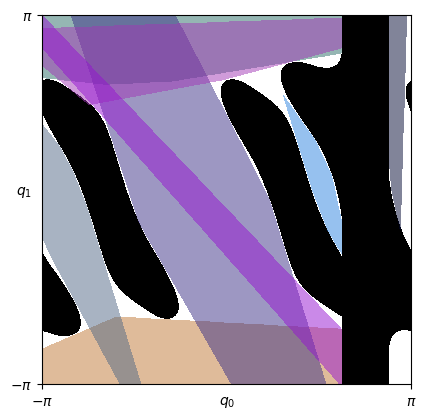

In [26]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))

for region in vcc_regions:
    color = Rgba(np.random.uniform(), np.random.uniform(), np.random.uniform(), 0.5)
    visualize2dIrisPolytope(plt, checker.plant(), region, N, color)

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

#### Using MOSEK MIP MaxClique solver

In [27]:
pre_existing_regions = []
vcc_regions = IrisInConfigurationSpaceFromCliqueCover(
    checker, vcc_opts, RandomGenerator(1337), pre_existing_regions, MaxCliqueSolverViaMip()
)

INFO:drake:Current Fraction of Domain Covered = 0
INFO:drake:IrisFromCliqueCover Iteration 1/100
INFO:drake:Clique added to queue. There are 40/100 points left to cover.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:Clique added to queue. There are 23/100 points left to cover.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:Clique added to queue. There are 9/100 points left to cover.
INFO:drake:Finished adding cliques. Total of 3 clique added. Number of cliques left to process = 0
INFO:drake:3 new sets added in IrisFromCliqueCover at iteration 0. Total sets = 3
INFO:drake:Current Fraction of Domain Covered = 0.7588
INFO:drake:IrisFromCliqueCover Iteration 2/100
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the ite

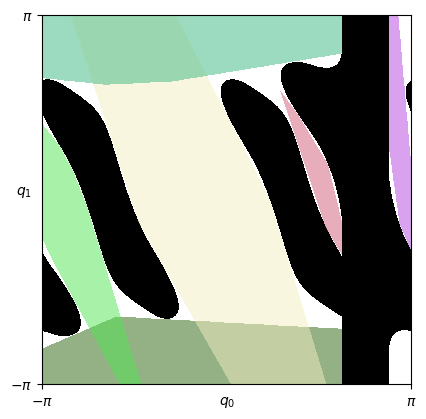

In [28]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))

for region in vcc_regions:
    color = Rgba(np.random.uniform(), np.random.uniform(), np.random.uniform(), 0.5)
    visualize2dIrisPolytope(plt, checker.plant(), region, N, color)

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

## Using the manual implementation of the Visibility Clique Covering (VCC) algorithm

In [29]:
vcc_opts = IrisFromCliqueCoverOptions()

vcc_opts.coverage_termination_threshold = 0.9
vcc_opts.num_points_per_visibility_round = 100
vcc_opts.num_points_per_coverage_check = 5000
vcc_opts.minimum_clique_size = 10

In [30]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/2dofScene0.dmd.yaml"))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("2dofPlanarArm") ],
    edge_step_size=0.1,
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


In [31]:
class DrakeRandomGenerator():
    def __init__(
            self,
            domain: HPolyhedron,
            randomGenerator: RandomGenerator
        ) -> None:

        self.domain = domain
        self.randomGenerator = randomGenerator
        self.lastSample = None


    def randomConfig(
            self
            ):
        if self.lastSample is None:
            self.lastSample = self.domain.UniformSample(self.randomGenerator)
        else:
            self.lastSample = self.domain.UniformSample(self.randomGenerator, self.lastSample)

        return self.lastSample


#### Using greedy MaxClique solver

In [32]:
qLowerBounds = plant.GetPositionLowerLimits()
qUpperBounds = plant.GetPositionUpperLimits()

domain = HPolyhedron.MakeBox(qLowerBounds, qUpperBounds)
randomGenerator = DrakeRandomGenerator(domain, RandomGenerator(1337))

vcc_regions, coverage = VisibilityCliqueCover(checker, MaxCliqueSolverViaGreedy(), vcc_opts, randomGenerator.randomConfig)
print("Coverage: " + str(coverage))
print("Num. of regions: " + str(len(vcc_regions)))

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has

Coverage: 0.9184
Num. of regions: 9


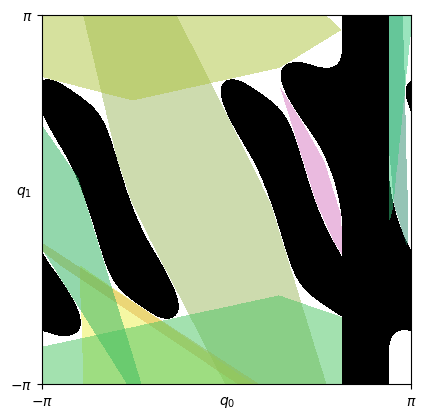

In [33]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))

for region in vcc_regions:
    color = Rgba(np.random.uniform(), np.random.uniform(), np.random.uniform(), 0.5)
    visualize2dIrisPolytope(plt, checker.plant(), region, N, color)

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

#### Using MOSEK MIP MaxClique solver

In [34]:
qLowerBounds = plant.GetPositionLowerLimits()
qUpperBounds = plant.GetPositionUpperLimits()

domain = HPolyhedron.MakeBox(qLowerBounds, qUpperBounds)
randomGenerator = DrakeRandomGenerator(domain, RandomGenerator(1337))

vcc_regions, coverage = VisibilityCliqueCover(checker, MaxCliqueSolverViaMip(), vcc_opts, randomGenerator.randomConfig)
print("Coverage: " + str(coverage))
print("Num. of regions: " + str(len(vcc_regions)))

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has

Coverage: 0.912
Num. of regions: 8


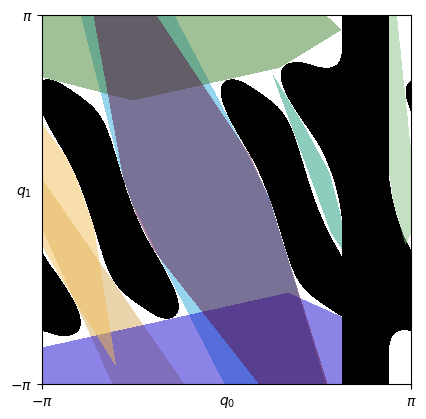

In [35]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))

for region in vcc_regions:
    color = Rgba(np.random.uniform(), np.random.uniform(), np.random.uniform(), 0.5)
    visualize2dIrisPolytope(plt, checker.plant(), region, N, color)

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

## Generalized bur

In [36]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/2dofScene0.dmd.yaml"))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("2dofPlanarArm") ],
    edge_step_size=0.1,
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


In [37]:
jointChildAndEndEffectorLinks = [
    plant.GetBodyByName("2dofPlanarLink1", plant.GetModelInstanceByName("2dofPlanarArm")),
    plant.GetBodyByName("2dofPlanarLink2", plant.GetModelInstanceByName("2dofPlanarArm")),
    plant.GetBodyByName("2dofPlanarEndEffector", plant.GetModelInstanceByName("2dofPlanarArm"))
]

planarArm = PlanarArm(
    checker,
    jointChildAndEndEffectorLinks,
    [0.1] * 2
)

### Ordinary bur (Zeroth order GBur)

In [38]:
gBurConfigs = GeneralizedBurConfig(
    20,
    0,
    0.00001,
    0.01
)

gBurCenter = [0, 0]

qLowerBounds = plant.GetPositionLowerLimits()
qUpperBounds = plant.GetPositionUpperLimits()
np.random.seed(100)

randomGenerator = partial(np.random.uniform, low = qLowerBounds, high = qUpperBounds)

In [39]:
gBur = GeneralizedBur(
    gBurCenter,
    gBurConfigs,
    planarArm,
    randomGenerator
)

layers, _ = gBur.calculateBur()

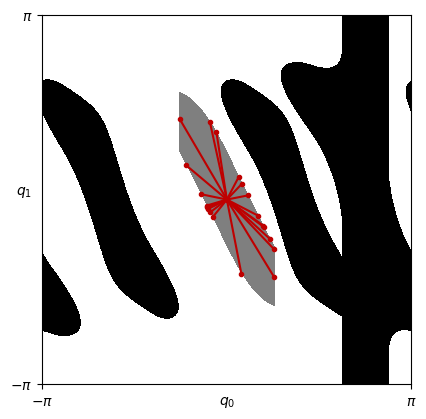

In [40]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))
visualize2dCompleteBubble(plt, checker, jointChildAndEndEffectorLinks, gBurCenter, N, Rgba(0.5, 0.5, 0.5, 1))
visualize2dGeneralizedBur(
    plt, checker, gBur, N, [
        Rgba(0.75, 0, 0, 1)
        ]
    )

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

### Second order GBur

In [41]:
gBurConfigs = GeneralizedBurConfig(
    20,
    2,
    0.00001,
    0.01
)

gBurCenter = [0, 0]

qLowerBounds = plant.GetPositionLowerLimits()
qUpperBounds = plant.GetPositionUpperLimits()
np.random.seed(100)

# The random generator can be any function that returns a configuration
randomGenerator = partial(np.random.uniform, low = qLowerBounds, high = qUpperBounds)

In [42]:
gBur = GeneralizedBur(
    gBurCenter,
    gBurConfigs,
    planarArm,
    randomGenerator
)

layers, _ = gBur.calculateBur()

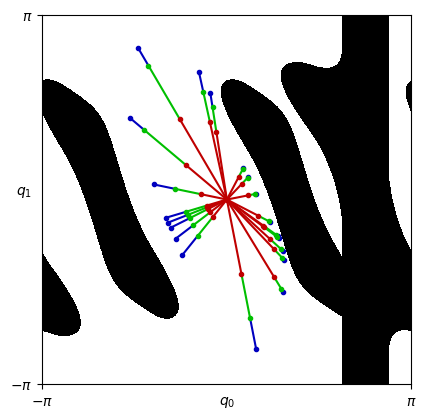

In [43]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))
visualize2dGeneralizedBur(
    plt, checker, gBur, N, [
        Rgba(0.75, 0, 0, 1),
        Rgba(0, 0.75, 0, 1), 
        Rgba(0, 0, 0.75, 1)
        ]
    )

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

## GBur-IRIS (generalized bur + IRIS)

In [44]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/2dofScene0.dmd.yaml"))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("2dofPlanarArm") ],
    edge_step_size=0.1,
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


In [45]:
jointChildAndEndEffectorLinks = [
    plant.GetBodyByName("2dofPlanarLink1", plant.GetModelInstanceByName("2dofPlanarArm")),
    plant.GetBodyByName("2dofPlanarLink2", plant.GetModelInstanceByName("2dofPlanarArm")),
    plant.GetBodyByName("2dofPlanarEndEffector", plant.GetModelInstanceByName("2dofPlanarArm"))
]

planarArm = PlanarArm(
    checker,
    jointChildAndEndEffectorLinks,
    [0.1] * 2
)

In [46]:
class DrakeRandomGenerator():
    def __init__(
            self,
            domain: HPolyhedron,
            randomGenerator: RandomGenerator
        ) -> None:

        self.domain = domain
        self.randomGenerator = randomGenerator
        self.lastSample = None


    def randomConfig(
            self
            ):
        if self.lastSample is None:
            self.lastSample = self.domain.UniformSample(self.randomGenerator)
        else:
            self.lastSample = self.domain.UniformSample(self.randomGenerator, self.lastSample)

        return self.lastSample


### Three iterations of the GBur-IRIS algoritm

In [47]:
gBurIRISconfigs = GBurIRISConfig(
    7,
    4,
    0.00001,
    0.01,
    5000,
    0.9,
    3
)

gBurCenter = [0, 0]

qLowerBounds = plant.GetPositionLowerLimits()
qUpperBounds = plant.GetPositionUpperLimits()

domain = HPolyhedron.MakeBox(qLowerBounds, qUpperBounds)
randomGenerator = DrakeRandomGenerator(domain, RandomGenerator(117))

In [48]:
gBurIRISregions, coverage, gBurs = GBurIRIS(
    checker,
    planarArm,
    gBurIRISconfigs,
    randomGenerator.randomConfig
)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


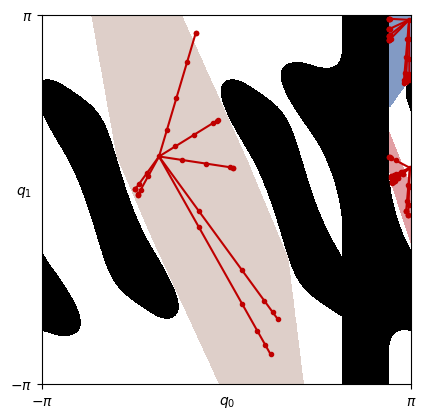

In [49]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))

for region, bur in zip(gBurIRISregions, gBurs):
    color = Rgba(np.random.uniform(), np.random.uniform(), np.random.uniform(), 0.5)
    visualize2dIrisPolytope(plt, checker.plant(), region, N, color)
    visualize2dGeneralizedBur(plt, checker, bur, N, [ Rgba(0.75, 0, 0, 1) ] * 5)

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

### GBur-IRIS with coverage termination

In [50]:
gBurIRISconfigs = GBurIRISConfig(
    7,
    4,
    0.00001,
    0.01,
    5000,
    0.9,
    100
)

gBurCenter = [0, 0]

qLowerBounds = plant.GetPositionLowerLimits()
qUpperBounds = plant.GetPositionUpperLimits()

domain = HPolyhedron.MakeBox(qLowerBounds, qUpperBounds)
randomGenerator = DrakeRandomGenerator(domain, RandomGenerator(117))

In [51]:
gBurIRISregions, coverage, gBurs = GBurIRIS(
    checker,
    planarArm,
    gBurIRISconfigs,
    randomGenerator.randomConfig
)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has

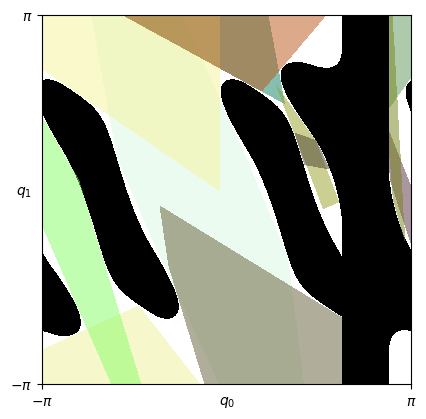

In [52]:
N = 1000
visualize2dConfigSpace(plt, checker, N, Rgba(0, 0, 0, 1))

for region in gBurIRISregions:
    color = Rgba(np.random.uniform(), np.random.uniform(), np.random.uniform(), 0.5)
    visualize2dIrisPolytope(plt, checker.plant(), region, N, color)

plt.xticks([0, N-1], ["$-\pi$", "$\pi$"])
plt.yticks([0, N-1], ["$\pi$", "$-\pi$"])
plt.xlabel("$q_0$", labelpad=-10)
_ = plt.ylabel("$q_1$", labelpad=-10, rotation=0)

## VCC and GBur-IRIS comparison

First run all the cells for the desired manipulator, the run the cells in the run section. 

In [106]:
class DrakeRandomGenerator():
    def __init__(
            self,
            domain: HPolyhedron,
            randomGenerator: RandomGenerator
        ) -> None:

        self.domain = domain
        self.randomGenerator = randomGenerator
        self.lastSample = None


    def randomConfig(
            self
            ):
        if self.lastSample is None:
            self.lastSample = self.domain.UniformSample(self.randomGenerator)
        else:
            self.lastSample = self.domain.UniformSample(self.randomGenerator, self.lastSample)

        return self.lastSample


### 2DOF planar arm

In [107]:
sceneNumber2DOF = 1

In [108]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/2dofScene%d.dmd.yaml" % sceneNumber2DOF))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("2dofPlanarArm") ],
    edge_step_size=0.1,
)

jointChildAndEndEffectorLinks = [
    plant.GetBodyByName("2dofPlanarLink1", plant.GetModelInstanceByName("2dofPlanarArm")),
    plant.GetBodyByName("2dofPlanarLink2", plant.GetModelInstanceByName("2dofPlanarArm")),
    plant.GetBodyByName("2dofPlanarEndEffector", plant.GetModelInstanceByName("2dofPlanarArm"))
]

robot = PlanarArm(
    checker,
    jointChildAndEndEffectorLinks,
    [0.1] * 2
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


In [109]:
vcc_opts = IrisFromCliqueCoverOptions()

vcc_opts.coverage_termination_threshold = 0.9
vcc_opts.num_points_per_visibility_round = 500
vcc_opts.num_points_per_coverage_check = 5000
vcc_opts.minimum_clique_size = 10

In [110]:
gBurIRISconfigs = GBurIRISConfig(
    7,
    4,
    0.01,
    0.01,
    5000,
    0.9,
    100,
    1,
    True
)

### 3DOF anthropomorphic arm

In [72]:
sceneNumber3DOF = 1

In [73]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/3dofScene%d.dmd.yaml" % sceneNumber3DOF))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("AnthropomorphicArm") ],
    edge_step_size=0.1,
)

bodyIndices = plant.GetBodyIndices(plant.GetModelInstanceByName("AnthropomorphicArm"))

for i in range(len(bodyIndices)):
    for j in range(i+1, len(bodyIndices)):
        checker.SetCollisionFilteredBetween(bodyIndices[i], bodyIndices[j], True)

jointChildAndEndEffectorLinks = [
    plant.GetBodyByName("AnthropomorphicArmLink1", plant.GetModelInstanceByName("AnthropomorphicArm")),
    plant.GetBodyByName("AnthropomorphicArmLink2", plant.GetModelInstanceByName("AnthropomorphicArm")),
    plant.GetBodyByName("AnthropomorphicArmLink3", plant.GetModelInstanceByName("AnthropomorphicArm")),
    plant.GetBodyByName("AnthropomorphicArmEndEffector", plant.GetModelInstanceByName("AnthropomorphicArm"))
]


robot = AnthropomorphicArm(
    checker,
    jointChildAndEndEffectorLinks,
    [0.1] * 3
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


In [74]:
vcc_opts = IrisFromCliqueCoverOptions()

vcc_opts.coverage_termination_threshold = 0.6
vcc_opts.num_points_per_visibility_round = 500
vcc_opts.num_points_per_coverage_check = 5000
vcc_opts.minimum_clique_size = 10

In [75]:
gBurIRISconfigs = GBurIRISConfig(
    7,
    4,
    0.01,
    0.01,
    5000,
    0.6,
    100,
    1,
    True
)

### 6DOF planar arm

In [99]:
sceneNumber6DOF = 1

In [100]:
builder = RobotDiagramBuilder()
plant = builder.plant()

parser = Parser(plant)
parser.package_map().Add("assets", os.path.join(os.path.dirname(os.path.abspath("__file__")), "assets"))
parser.AddModels(os.path.join(filePath, "scenes/6dofScene%d.dmd.yaml" % sceneNumber6DOF))
plant.Finalize()

diagram = builder.Build()

# If the plant context is need it can be derived from the diagram (context)
diagramContext = diagram.CreateDefaultContext()

checker = SceneGraphCollisionChecker(
    model=diagram,
    robot_model_instances=[ plant.GetModelInstanceByName("6dofPlanarArm") ],
    edge_step_size=0.1,
)

jointChildAndEndEffectorLinks = [
    plant.GetBodyByName("6dofPlanarLink1", plant.GetModelInstanceByName("6dofPlanarArm")),
    plant.GetBodyByName("6dofPlanarLink2", plant.GetModelInstanceByName("6dofPlanarArm")),
    plant.GetBodyByName("6dofPlanarLink3", plant.GetModelInstanceByName("6dofPlanarArm")),
    plant.GetBodyByName("6dofPlanarLink4", plant.GetModelInstanceByName("6dofPlanarArm")),
    plant.GetBodyByName("6dofPlanarLink5", plant.GetModelInstanceByName("6dofPlanarArm")),
    plant.GetBodyByName("6dofPlanarLink6", plant.GetModelInstanceByName("6dofPlanarArm")),
    plant.GetBodyByName("6dofPlanarEndEffector", plant.GetModelInstanceByName("6dofPlanarArm"))
]

robot = PlanarArm(
    checker,
    jointChildAndEndEffectorLinks,
    [0.1] * 6
)

INFO:drake:Allocating contexts to support implicit context parallelism 4


In [101]:
vcc_opts = IrisFromCliqueCoverOptions()

vcc_opts.coverage_termination_threshold = 0.2
vcc_opts.num_points_per_visibility_round = 500
vcc_opts.num_points_per_coverage_check = 5000
vcc_opts.minimum_clique_size = 10

In [102]:
gBurIRISconfigs = GBurIRISConfig(
    7,
    4,
    0.01,
    0.01,
    5000,
    0.2,
    100,
    1,
    True
)

### Run

In [111]:
qLowerBounds = plant.GetPositionLowerLimits()
qUpperBounds = plant.GetPositionUpperLimits()

domain = HPolyhedron.MakeBox(qLowerBounds, qUpperBounds)
randomGenerator = DrakeRandomGenerator(domain, RandomGenerator(1337))

#### Run VCC

In [112]:
numOfRegionsVCC, coveragesVCC, timesVCC = [], [], []
numOfRunsVCC = 10

In [113]:
i = 0
while i < numOfRunsVCC:
    domain = HPolyhedron.MakeBox(qLowerBounds, qUpperBounds)
    randomGenerator = DrakeRandomGenerator(domain, RandomGenerator(np.random.randint(5500, 10000)))

    try:
        start = timer()
        vcc_regions, coverage = VisibilityCliqueCover(
            checker,
            MaxCliqueSolverViaGreedy(),
            vcc_opts,
            randomGenerator.randomConfig
        )
        end = timer()
    except:
        continue

    numOfRegionsVCC.append(len(vcc_regions))
    coveragesVCC.append(coverage)
    timesVCC.append(end - start)

    i += 1
    print("Run %d done." % i)

print("VCC results:")
print("\tRuntime [s]: %g+-%g" % (np.mean(timesVCC), np.std(timesVCC)))
print("\tNum. of regions: %g+-%g" % (np.mean(numOfRegionsVCC), np.std(numOfRegionsVCC)))
print("\tCoverage [%%]: %g+-%g" % (np.mean(coveragesVCC) * 100, np.std(coveragesVCC) * 100))

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 1 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 2 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 3 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 4 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 5 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 6 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 7 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 8 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 9 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 10 done.
VCC results:
	Runtime [s]: 36.0418+-5.15699
	Num. of regions: 3.7+-0.640312
	Coverage [%]: 96.434+-0.896484


#### Run GBur-IRIS

In [114]:
numOfRegionsGBurIRIS, coveragesGBurIRIS, timesGBurIRIS = [], [], []  
numOfRunsGBurIRIS = 10

In [115]:
i = 0
while i < numOfRunsGBurIRIS:
    domain = HPolyhedron.MakeBox(qLowerBounds, qUpperBounds)
    randomGenerator = DrakeRandomGenerator(domain, RandomGenerator(np.random.randint(5500, 10000)))

    try:
        start = timer()
        gBurIRISregions, coverage, _ = GBurIRIS(
            checker,
            robot,
            gBurIRISconfigs,
            randomGenerator.randomConfig
        )
        end = timer()
    except:
        continue

    numOfRegionsGBurIRIS.append(len(gBurIRISregions))
    coveragesGBurIRIS.append(coverage)
    timesGBurIRIS.append(end - start)

    i += 1
    print("Run %d done." % i)

print("GBur-IRIS results:")
print("\tRuntime [s]: %g+-%g" % (np.mean(timesGBurIRIS), np.std(timesGBurIRIS)))
print("\tNum. of regions: %g+-%g" % (np.mean(numOfRegionsGBurIRIS), np.std(numOfRegionsGBurIRIS)))
print("\tCoverage [%%]: %g+-%g" % (np.mean(coveragesGBurIRIS) * 100, np.std(coveragesGBurIRIS) * 100))

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 1 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 2 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 3 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 4 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 5 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 6 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 7 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 8 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 9 done.


INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace: Terminating because the iteration limit 1 has been reached.


Run 10 done.
GBur-IRIS results:
	Runtime [s]: 8.24058+-2.21479
	Num. of regions: 4+-1.26491
	Coverage [%]: 92.834+-1.08996


## References
* [Lacevic, B., Osmankovic, D., Ademovic, A., “Burs of free c-space: A novel structure for path planning”, IEEE ICRA, 2016
](https://ieeexplore.ieee.org/abstract/document/7487117)
* [Lacevic, B., Osmankovic, D., “Improved c-space exploration and path planning for robotic manipulators using distance information”, IEEE ICRA, 2020
](https://ieeexplore.ieee.org/document/9196920)
* [Deits, R., Tedrake, R., "Computing Large Convex Regions of Obstacle-Free Space Through Semidefinite Programming", Springer International Publishing, 2015
](https://link.springer.com/chapter/10.1007/978-3-319-16595-0_7)
* [Petersen, M., Tedrake, R., “Growing convex collision-free regions in configuration space using nonlinear programming”, arXiv, 2023
](https://arxiv.org/abs/2303.14737)
* [Werner, P., Amice, A., Marcucci, T., Rus, D., Tedrake, R., “Approximating robot configuration spaces with few convex sets using clique covers of visibility graphs”, IEEE ICRA, 2024
](https://ieeexplore.ieee.org/document/10610005)
* [The IRIS Builder for approximate convex decompositions of configuration space (notebook)](https://github.com/wernerpe/manipulation/blob/clique_seeding_manual_distribution/book/trajectories/iris_builder.ipynb)
* [Robotic Manipulation - Chapter 06 - Motion Planning (notebook)](https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/0762b167-402a-4362-9702-7d559f0e73bb/notebook/cspace-901b615b2bbf4036a560c9815db5a22e)
* [C-IRIS Pinball Example (notebook)](https://github.com/AlexandreAmice/drake/blob/C_Iris/C_Iris_Examples/pinball_iiwas.ipynb)
* [Drake (repository)](https://github.com/RobotLocomotion/drake)